<a href="https://colab.research.google.com/github/sumaila-ali/Stock-Price-Prediction/blob/main/Stock_Closing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow keras-tuner > /dev/null 2>&1

In [2]:
#Packages
from google.colab import auth
import gspread
from google.auth import default
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch


In [4]:
# Google sheet authentication
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
workbook = gc.open('Stock Market')
worksheet = workbook.worksheet("Data Source")

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
df = pd.DataFrame.from_records(rows)

#df = df.T
#grab the first row for the header
new_header = df.iloc[0]

#take the data less the header row
df = df[1:]

#set the header row as the df header
df.columns = new_header

# Use the first column as the index for the dataframe
df = df.set_index("Date")

df.head()
#df.tail()


,Close
Date,
3/27/2014 16:00:00,27.85
3/28/2014 16:00:00,27.92
3/31/2014 16:00:00,27.77
4/1/2014 16:00:00,28.28
4/2/2014 16:00:00,28.27


In [ ]:
# Load your data
# df = pd.read_csv('your_data.csv')
data = df['Close'].values  # Replace with your column name
data = data.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define sequence length
sequence_length = 365

# Create sequences and labels
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=False,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
        loss='mean_squared_error'
    )
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_search',
    project_name='lstm_time_series'
)

# Run hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Trial 10 Complete [00h 06m 26s]
val_loss: 0.0004250801866874099

Best val_loss So Far: 0.0003935139102395624
Total elapsed time: 00h 57m 15s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2,
                         batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 883ms/step - loss: 0.0296 - val_loss: 6.3190e-04
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 885ms/step - loss: 8.7959e-04 - val_loss: 4.0167e-04
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 872ms/step - loss: 6.1375e-04 - val_loss: 4.1871e-04
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 829ms/step - loss: 8.0099e-04 - val_loss: 6.7168e-04
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 816ms/step - loss: 6.7628e-04 - val_loss: 4.3487e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 806ms/step - loss: 7.6552e-04 - val_loss: 3.8091e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 839ms/step - loss: 6.4332e-04 - val_loss: 4.0784e-04
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 882ms/step - loss: 7.2457e-04 - val_loss: 4.2511e-04
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 828ms/step - loss: 6.3673e-04 - val_loss: 4.5586e-04
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 824ms/step - loss: 6.1919e-04 - val_loss: 3.4943e-04
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 821ms/step

In [ ]:
# Evaluate the model
mse = best_model.evaluate(X_test, y_test)
print(f"Test Mean Squared Error: {mse}")

# Predict on test data
predicted = best_model.predict(X_test)

# Inverse transform predictions and true values
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - loss: 2.9766e-04
Test Mean Squared Error: 0.00032484609982930124
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step


In [ ]:
last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
next_prediction = best_model.predict(last_sequence)
next_prediction = scaler.inverse_transform(next_prediction)

print(f"Next Step Prediction: {next_prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Next Step Prediction: 197.73538208007812


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted, label='Predicted Values', linestyle='dashed')
plt.title('LSTM Predictions vs True Values')
plt.legend()
plt.show()

In [ ]:
train_size = int(len(scaled_data) * 0.95)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, 0])
        y.append(data[i+sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 7  # Number of past time steps
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



def build_model(hp):
    model = Sequential()

    # Add LSTM layers
    for i in range(hp.Int('num_layers', 1, 3)):  # Number of layers (1-3)
        model.add(LSTM(
            units=hp.Int('units_' + str(i), 32, 128, step=32),  # Units (32-128)
            return_sequences=(i != hp.Int('num_layers', 1, 3) - 1),  # Return sequences for all but last layer
            input_shape=(sequence_length, 1) if i == 0 else None))
        model.add(Dropout(hp.Float('dropout_rate_' + str(i), 0.1, 0.3, step=0.1)))  # Dropout rate (0.1-0.3)

    # Add Dense output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

In [ ]:
model = Sequential([
    LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(60, return_sequences=False),
    Dense(30),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(X_train, y_train, batch_size=50, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0363 - val_loss: 0.0055
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3724e-04 - val_loss: 0.0013
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5868e-04 - val_loss: 0.0011
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.4899e-04 - val_loss: 0.0011
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.5645e-04 - val_loss: 0.0011
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3395e-04 - val_loss: 0.0014
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6725e-04 - val_loss: 0.0011
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3248e-04 - val_loss: 0.0011
Epoch 9/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4113e-04 - val_loss: 0.0011
Epoch 10/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2683e-04 - val_loss: 0.0011
Epoch 11/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4401e-04 - val_loss: 0.0011
Epoch 12/30
52/52 ━━━━━

In [ ]:
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)  # Reverse scaling

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


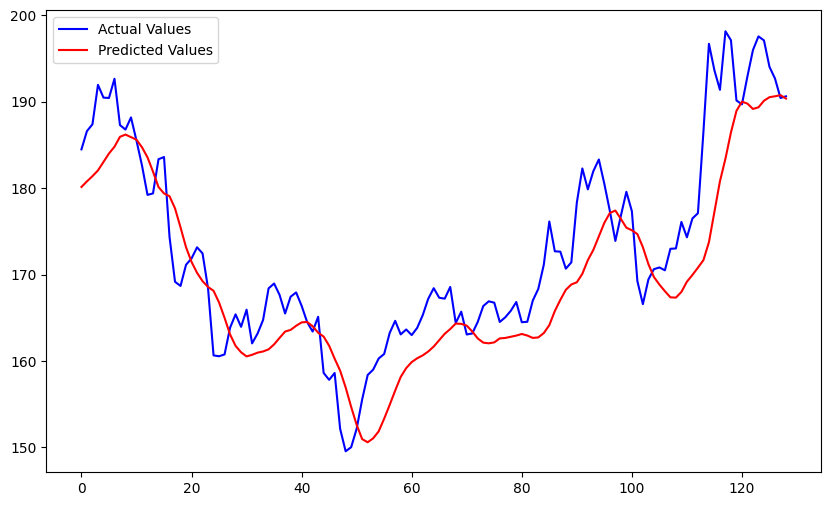

In [ ]:
import matplotlib.pyplot as plt

actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')
plt.legend()
plt.show()

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of model evaluations per combination
    directory='my_tuner_dir',
    project_name='lstm_hyperparam_tuning'
)

In [ ]:
sequence_length = 60  # Define a fixed sequence length
# Assume X_train, y_train, X_val, y_val are ready for training

In [ ]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Trial 10 Complete [00h 03m 17s]
val_mae: 0.02069648914039135

Best val_mae So Far: 0.016841087490320206
Total elapsed time: 00h 47m 10s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Layer {i + 1} units: {best_hps.get('units_' + str(i))}")
    print(f"Layer {i + 1} dropout: {best_hps.get('dropout_rate_' + str(i))}")
print(f"Optimal optimizer: {best_hps.get('optimizer')}")

Optimal number of layers: 1
Layer 1 units: 128
Layer 1 dropout: 0.2
Optimal optimizer: rmsprop


In [ ]:
from itertools import product

param_grid = {
    'units': [32, 64, 128],
    'num_layers': [1, 2],
    'dropout_rate': [0.1, 0.2],
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.01]
}

# Create all combinations
param_combinations = list(product(*param_grid.values()))

In [ ]:
from sklearn.model_selection import train_test_split

best_model = None
best_score = float('inf')

for params in param_combinations:
    units, num_layers, dropout_rate, batch_size, learning_rate = params

    # Create the model
    model = Sequential()
    for _ in range(num_layers):
        model.add(LSTM(units, return_sequences=True, input_shape=(sequence_length, 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=10, batch_size=batch_size, verbose=0)

    # Evaluate the model
    val_mae = history.history['val_mae'][-1]
    if val_mae < best_score:
        best_model = model
        best_score = val_mae